In [1]:
#Importing needed packages

%matplotlib inline
from matplotlib import pyplot as plt #for plotting results
import sklearn, re #Regulaer expression and sklearn 
import numpy as np #linear algebra
import pandas as pd #data processing, .csv file I/O
from sklearn.preprocessing import StandardScaler #to scale the data
from sklearn.impute import SimpleImputer #to fill up the missing values
from sklearn import preprocessing
from sklearn.decomposition import PCA #principle component analysis
from sklearn.impute import KNNImputer 
from sklearn.neighbors import KNeighborsClassifier #K nearest neighbor
from sklearn.cluster import KMeans #k-means module
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score, homogeneity_score
from sklearn import metrics
from numpy import random


In [2]:
#dataset paths

#77_cancer_proteomes.csv contains protein data with unique 
#ID(RefSeq) for each protein, gene_symbol,and last 3 columns are from healthy patients
data = pd.read_csv('C:/Users/Enigma/Desktop/Small project/77_cancer_proteomes_CPTAC_itraq.csv', index_col = 0)


#clinical_data_breast_cancer.csv is used 
#to match the sample IDs in the main cancer proteomes file
clinical = pd.read_csv('C:/Users/Enigma/Desktop/Small project/clinical_data_breast_cancer.csv', index_col = 0)


#contains list of genes and proteins used by 
#PAM50 classification system. RefSeqProteinID is used to match with IDs in clinical file
PAM50 = pd.read_csv('C:/Users/Enigma/Desktop/Small project/PAM50_proteins.csv', index_col = 0)



In [3]:
#Dropping unnecessary columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)

In [4]:
#Renaming the column according to our needs to make it 
#easier to match with the column in other file
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)

In [5]:
## Transpose data for the clustering algorithm
#since we want to divide patient samples, not proteins
data = data.transpose()

In [6]:
## Drop clinical entries for samples not in our protein
#data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data.index],:]

In [7]:
#Merging two tables
merged = data.merge(clinical,left_index=True,right_index=True)

In [8]:
#Transfering matched column data to other object
processed = merged

In [9]:
### Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers 
#from RefSeq database
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]

In [10]:
## Select only the PAM50 proteins - known panel of genes used for 
#breast cancer subtype prediction
processed_numerical_p50 = processed_numerical.iloc[:,processed_numerical.columns.isin(PAM50['RefSeqProteinID'])]

In [11]:
#Impute missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(processed_numerical_p50)
processed_numerical_p50 = imputer.transform(processed_numerical_p50)

In [12]:
#check number of clusters that would work fine
#it is trial here trying 20 and 79
n_clusters = [2,3,4,5,6,7,8,10,20,79]

def compare_k_means(k_list,data):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = KMeans(n_clusters=k, n_jobs=4)
        clusterer.fit(data)
        ## The higher (up to 1) the better
        print("Silhouette Coefficient for k == %s: %s" % (
        k, round(metrics.silhouette_score(data, clusterer.labels_), 4)))
        print("Homogeneity score for k == %s: %s" % (
        k, round(metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_),4)))
        print("------------------------")


In [13]:
#Create a random numerical matrix with imputation
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)

In [14]:
#Check different number of clusters for PAM50 protiens
compare_k_means(n_clusters,processed_numerical_p50)

Silhouette Coefficient for k == 2: 0.211
Homogeneity score for k == 2: 0.2073
------------------------
Silhouette Coefficient for k == 3: 0.1748
Homogeneity score for k == 3: 0.4159
------------------------
Silhouette Coefficient for k == 4: 0.1429
Homogeneity score for k == 4: 0.4314
------------------------
Silhouette Coefficient for k == 5: 0.136
Homogeneity score for k == 5: 0.4995
------------------------
Silhouette Coefficient for k == 6: 0.1174
Homogeneity score for k == 6: 0.5228
------------------------
Silhouette Coefficient for k == 7: 0.1195
Homogeneity score for k == 7: 0.5494
------------------------
Silhouette Coefficient for k == 8: 0.104
Homogeneity score for k == 8: 0.561
------------------------
Silhouette Coefficient for k == 10: 0.0975
Homogeneity score for k == 10: 0.6338
------------------------
Silhouette Coefficient for k == 20: 0.0903
Homogeneity score for k == 20: 0.6944
------------------------
Silhouette Coefficient for k == 79: 0.0087
Homogeneity score for

In [15]:
#Use random protiens for comparison
#The scores should be significantly lower for PAM50 protiens
compare_k_means(n_clusters,processed_numerical_random)

Silhouette Coefficient for k == 2: 0.113
Homogeneity score for k == 2: 0.0337
------------------------
Silhouette Coefficient for k == 3: 0.0988
Homogeneity score for k == 3: 0.06
------------------------
Silhouette Coefficient for k == 4: 0.0788
Homogeneity score for k == 4: 0.1194
------------------------
Silhouette Coefficient for k == 5: 0.0644
Homogeneity score for k == 5: 0.099
------------------------
Silhouette Coefficient for k == 6: 0.0667
Homogeneity score for k == 6: 0.185
------------------------
Silhouette Coefficient for k == 7: 0.0602
Homogeneity score for k == 7: 0.235
------------------------
Silhouette Coefficient for k == 8: 0.068
Homogeneity score for k == 8: 0.2303
------------------------
Silhouette Coefficient for k == 10: 0.0567
Homogeneity score for k == 10: 0.2276
------------------------
Silhouette Coefficient for k == 20: 0.0704
Homogeneity score for k == 20: 0.4677
------------------------
Silhouette Coefficient for k == 79: 0.0121
Homogeneity score for k 

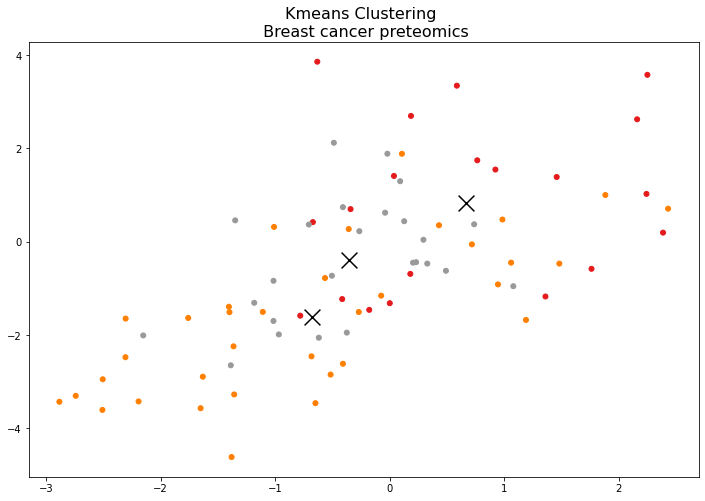

In [16]:
#visualize data using k=3

import seaborn as sns
clusterer_final = KMeans(n_clusters=3, n_jobs=4)
clusterer_final = clusterer_final.fit(processed_numerical_p50)
processed_p50_plot = pd.DataFrame(processed_numerical_p50)
processed_p50_plot['KMeans_cluster'] = clusterer_final.labels_
processed_p50_plot.sort_values('KMeans_cluster',axis=0,inplace=True)

fig = plt.figure(figsize=(12,8))
plt.scatter(processed_numerical_p50[:,0], processed_numerical_p50[:,1], c=clusterer_final.labels_, cmap="Set1_r", s=25)
plt.scatter(clusterer_final.cluster_centers_[:,0] ,clusterer_final.cluster_centers_[:,1], color='black', marker="x", s=250)
plt.title("Kmeans Clustering \n Breast cancer preteomics", fontsize=16)
plt.show()

In [17]:
#building PCA model
for n_component in range(1, 16, 2):
    pca = PCA(n_components=n_component)
    reduced_data = pca.fit_transform(processed_numerical_p50)
    print('\nComponents: {}'.format(n_component))
    print('% of Variance Explained: {}'.format(sum(pca.explained_variance_ratio_)))
    compare_k_means(n_clusters, reduced_data)


Components: 1
% of Variance Explained: 0.36337092861806597
Silhouette Coefficient for k == 2: 0.5731
Homogeneity score for k == 2: 0.2073
------------------------
Silhouette Coefficient for k == 3: 0.5711
Homogeneity score for k == 3: 0.2599
------------------------
Silhouette Coefficient for k == 4: 0.55
Homogeneity score for k == 4: 0.3077
------------------------
Silhouette Coefficient for k == 5: 0.5583
Homogeneity score for k == 5: 0.3385
------------------------
Silhouette Coefficient for k == 6: 0.5716
Homogeneity score for k == 6: 0.3637
------------------------
Silhouette Coefficient for k == 7: 0.6023
Homogeneity score for k == 7: 0.3648
------------------------
Silhouette Coefficient for k == 8: 0.6106
Homogeneity score for k == 8: 0.3808
------------------------
Silhouette Coefficient for k == 10: 0.5888
Homogeneity score for k == 10: 0.4247
------------------------
Silhouette Coefficient for k == 20: 0.5959
Homogeneity score for k == 20: 0.523
------------------------
Sil

Silhouette Coefficient for k == 10: 0.1364
Homogeneity score for k == 10: 0.5608
------------------------
Silhouette Coefficient for k == 20: 0.101
Homogeneity score for k == 20: 0.6351
------------------------
Silhouette Coefficient for k == 79: 0.0087
Homogeneity score for k == 79: 1.0
------------------------


In [18]:
#After analysis kmeans clustering with 5 PCA components
pca=PCA(n_components=5)
ProteomicsX_pca=pca.fit(processed_numerical_p50)
ProteomicsX_pca2=ProteomicsX_pca.transform(processed_numerical_p50)
print(pca.explained_variance_ratio_)


[0.36337093 0.12581338 0.07865046 0.05877226 0.05236752]


In [19]:
n_clusters = 5
KMeansModel=KMeans(n_clusters=n_clusters, init='k-means++')
KMeanData=ProteomicsX_pca2
KMeansModel.fit(KMeanData)
labels=KMeansModel.labels_
centroids=KMeansModel.cluster_centers_
print("LABELS",labels)
print("----------------------------")
print("Centroids",centroids)

LABELS [2 2 4 0 3 4 1 2 1 0 3 0 0 4 2 2 1 1 1 1 4 1 3 4 0 1 2 4 3 2 1 0 3 3 4 4 2
 4 3 3 3 4 4 1 2 3 4 1 4 2 0 3 1 3 2 0 2 1 1 4 0 0 3 2 4 2 0 1 2 4 1 2 2 2
 4 4 2 3 2 4]
----------------------------
Centroids [[ -3.37434094   3.11455799  -5.1515231    1.55717342  -0.38795736]
 [ -4.78772214   1.00817546   4.31307237   1.42789285  -1.34238765]
 [ 11.48461812   3.39216799   0.48296458  -1.8084112   -0.28826151]
 [-13.34710904   0.33031528   0.17831769  -2.92285744   0.54402626]
 [  3.73097203  -6.46624836  -1.28937595   1.95331762   1.25761031]]


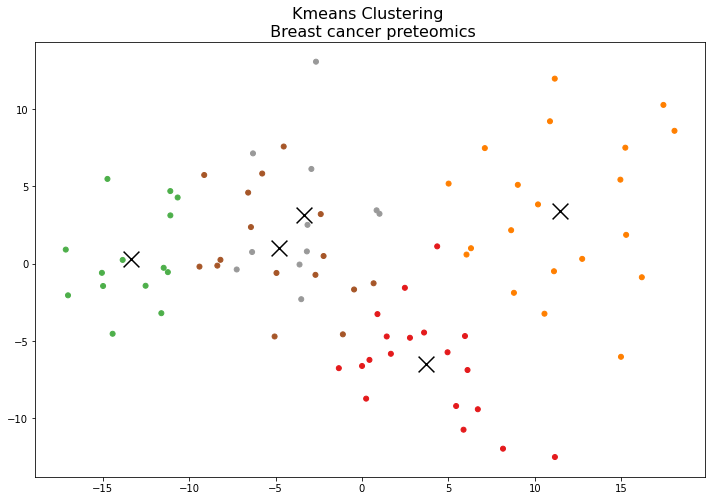

In [20]:
#Final visualization with X mark for centroids of each cluster
fig = plt.figure(figsize=(12,8))

plt.scatter(KMeanData[:,0], KMeanData[:,1], c=KMeansModel.labels_, cmap="Set1_r", s=25)
plt.scatter(KMeansModel.cluster_centers_[:,0] ,KMeansModel.cluster_centers_[:,1], color='black', marker="x", s=250)
plt.title("Kmeans Clustering \n Breast cancer preteomics", fontsize=16)
plt.show()